In [38]:
import pandas as pd
import os
import cv2
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
df = pd.read_csv(r'/Users/ethan/Downloads/new_kaggle_dataset/train.csv')
test_df = pd.read_csv(r'/Users/ethan/Downloads/Messidor2/messidor_data.csv')

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

test_df = test_df.drop(['adjudicated_dme', 'adjudicated_gradable'], axis=1)
test_df['type'] = test_df['adjudicated_dr_grade'].map(diagnosis_dict.get)
test_df.head()

,image_id,adjudicated_dr_grade,type
0,20051020_43808_0100_PP.png,0.0,No_DR
1,20051020_43832_0100_PP.png,1.0,Mild
2,20051020_43882_0100_PP.png,1.0,Mild
3,20051020_43906_0100_PP.png,2.0,Moderate
4,20051020_44261_0100_PP.png,0.0,No_DR


diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

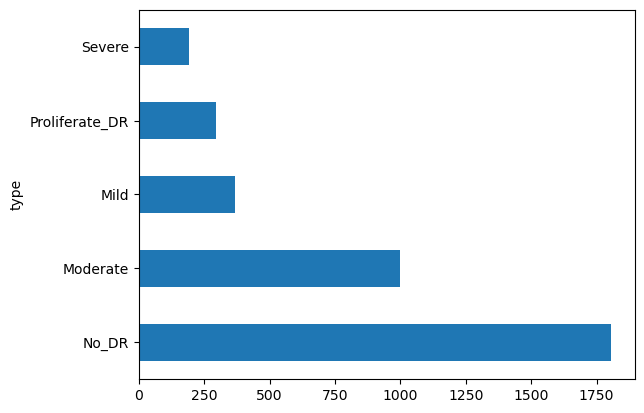

In [8]:
df['type'].value_counts().plot(kind='barh')
df['diagnosis'].value_counts()

In [11]:
main_directory = r'/Users/ethan/Downloads/new_kaggle_dataset/gaussian_filtered_images/gaussian_filtered_images'
classes = os.listdir(main_directory)

filepaths = []
labels = []

for _class in classes:
    class_path = os.path.join(main_directory, _class)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for file in file_list:
            file_path = os.path.join(class_path, file)
            filepaths.append(file_path)
            labels.append(_class)
trainPreprocessed_filepaths = []
trainPreprocessedDirectory = '/Users/ethan/Downloads/new_kaggle_dataset/train'
for file_path in filepaths:
    # Load the image
    img = cv2.imread(file_path)
    # Convert the image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply a median filter to reduce noise
    img = cv2.medianBlur(img, 5)
    # Enhance the contrast of the image using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    # Save the preprocessed image
    os.makedirs(trainPreprocessedDirectory, exist_ok=True)
    trainPreprocessed_path = os.path.join(trainPreprocessedDirectory, os.path.basename(file_path))
    cv2.imwrite(trainPreprocessed_path, img)
    trainPreprocessed_filepaths.append(trainPreprocessed_path)

Fseries=pd.Series(trainPreprocessed_filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
print (df.head())
print('df length: ', len(df))
print (df['labels'].value_counts())

                                           filepaths labels
0  /Users/ethan/Downloads/new_kaggle_dataset/trai...   Mild
1  /Users/ethan/Downloads/new_kaggle_dataset/trai...   Mild
2  /Users/ethan/Downloads/new_kaggle_dataset/trai...   Mild
3  /Users/ethan/Downloads/new_kaggle_dataset/trai...   Mild
4  /Users/ethan/Downloads/new_kaggle_dataset/trai...   Mild
df length:  3662
labels
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


In [12]:
sample_list = []
max_size = 1500
groups = df.groupby('labels')
for label in df['labels'].unique():                 
    group = groups.get_group(label)
    sample_count = len(group)    
    if sample_count > max_size:
        samples = group.sample(max_size, replace = False, weights = None, random_state = 123, axis = 0).reset_index(drop = True)
    else:
        samples = group.sample(frac = 1.0, replace = False, random_state = 123, axis = 0).reset_index(drop = True)
    sample_list.append(samples)
df = pd.concat(sample_list, axis = 0).reset_index(drop = True)
print (len(df))     
print (df['labels'].value_counts())

3357
labels
No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


In [14]:
working_dir = r'./'
aug_dir = os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)                 #Remove duplicated folders with all its content
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path = os.path.join(aug_dir,label)    
    os.mkdir(dir_path)                     #Creating a folder for each label with augmented images
print(os.listdir(aug_dir))

['Mild', 'Moderate', 'Proliferate_DR', 'Severe', 'No_DR']


In [16]:
target = 1500 # set the target count for each class in df
#generatedImgs = ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
generatedImgs = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
labelsGroups = df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group = labelsGroups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count = len(group)   # determine how many samples there are in this class  
    if sample_count <= target: # if the class has less than target number of images
        aug_img_count = 0
        delta = target - sample_count  # number of augmented images to create
        target_dir = os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen = generatedImgs.flow_from_dataframe( group,  x_col = 'filepaths', y_col = None, target_size=(224,224), 
                                          class_mode = None, batch_size = 1, shuffle = False, save_to_dir = target_dir, 
                                          save_prefix = 'aug-', save_format = 'jpg')
        while aug_img_count < delta:
            images = next(aug_gen)            
            aug_img_count += len(images)

Found 370 validated image filenames.
Found 999 validated image filenames.
Found 295 validated image filenames.
Found 193 validated image filenames.
Found 1500 validated image filenames.


In [17]:
aug = r'./aug'
auglist = os.listdir(aug)
print (auglist)
for _class in auglist:
    classpath = os.path.join(aug, _class)
    fileList = os.listdir(classpath)
    print('class: ', _class, '  file count: ', len(fileList))

['Mild', 'Moderate', 'Proliferate_DR', 'Severe', 'No_DR']
class:  Mild   file count:  1130
class:  Moderate   file count:  501
class:  Proliferate_DR   file count:  1205
class:  Severe   file count:  1307
class:  No_DR   file count:  0


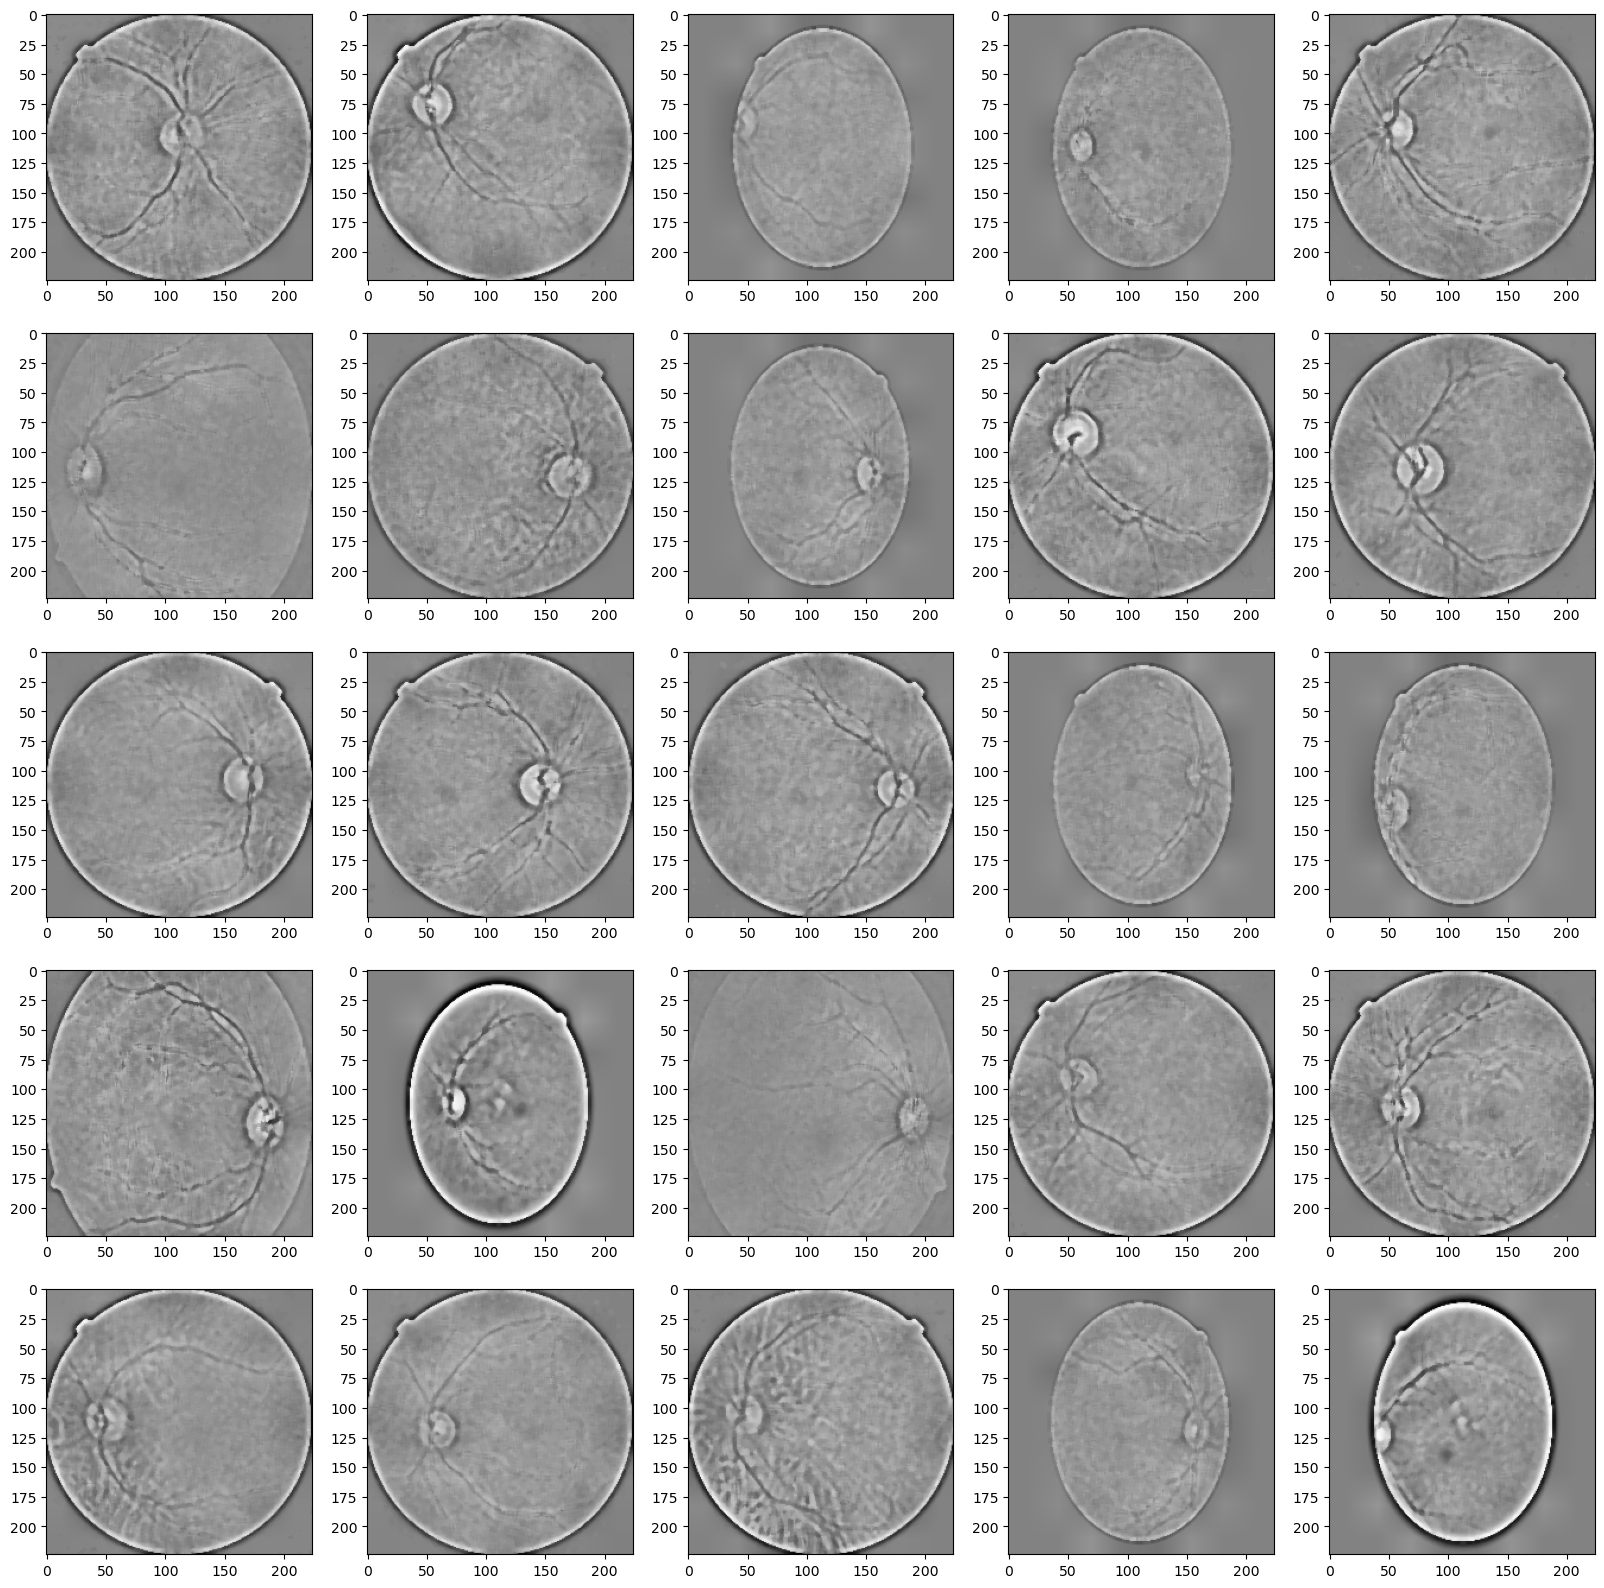

In [20]:
plt.figure(figsize = (20, 20))
for i in range(25):
    image = next(aug_gen)/255
    image = np.squeeze(image, axis=0)
    plt.subplot(5,5,i+1)
    plt.imshow(image)
plt.show()

In [21]:
aug_filePaths = []
aug_labels = []
classlist = os.listdir(aug_dir)
for klass in classlist:
    classpath = os.path.join(aug_dir, klass)     
    flist = os.listdir(classpath)    
    for f in flist:        
        fpath = os.path.join(classpath,f)         
        aug_filePaths.append(fpath)
        aug_labels.append(klass)
fileSeries = pd.Series(aug_filePaths, name = 'filepaths')
labelSeries = pd.Series(aug_labels, name = 'labels')
aug_df = pd.concat([fileSeries, labelSeries], axis = 1)
ndf = pd.concat([df,aug_df], axis = 0).reset_index(drop = True)


print (df['labels'].value_counts())  #Original labels count
print(aug_df['labels'].value_counts()) #Augmented labels count
print (ndf['labels'].value_counts()) #Concatenated labels count

labels
No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64
labels
Severe            1307
Proliferate_DR    1205
Mild              1130
Moderate           501
No_DR               25
Name: count, dtype: int64
labels
No_DR             1525
Mild              1500
Moderate          1500
Proliferate_DR    1500
Severe            1500
Name: count, dtype: int64


In [22]:
ndf.head()

,filepaths,labels
0,/Users/ethan/Downloads/new_kaggle_dataset/trai...,Mild
1,/Users/ethan/Downloads/new_kaggle_dataset/trai...,Mild
2,/Users/ethan/Downloads/new_kaggle_dataset/trai...,Mild
3,/Users/ethan/Downloads/new_kaggle_dataset/trai...,Mild
4,/Users/ethan/Downloads/new_kaggle_dataset/trai...,Mild


In [24]:
#Train, validation and test split
train_split = 0.8
valid_split = 0.2
train_df, valid_df = train_test_split(ndf, train_size = train_split, shuffle = True, random_state = 42) #Split whole dataset into train and what is left
print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df))

train_df length:  6020   valid_df length:  1505


In [ ]:
import os
import pandas as pd

testDirectory = '/kaggle/input/messidor2preprocess/messidor-2/messidor-2/preprocess'
#testDirectory = '/kaggle/input/idr-for-testing/IDR Test Images'


test_filepaths = []
test_labels = []

# for index, row in test_df.iterrows():
#     #file_name = row['Image name']
#     file_name = row['id_code']
#     #file_name = file_name + '.jpg'
#     file_path = os.path.join(testDirectory, file_name)
#     if os.path.exists(file_path):
#         test_filepaths.append(file_path)
#         test_labels.append(row['type'])


for index, row in test_df.iterrows():
    file_name = row['id_code']
    file_path = os.path.join(testDirectory, file_name)
    if os.path.exists(file_path):
        # Load the image
        img = cv2.imread(file_path)
        # Convert the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply a median filter to reduce noise
        img = cv2.medianBlur(img, 5)
        # Enhance the contrast of the image using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        # Save the preprocessed image
        testPreprocessedDirectory = '/kaggle/working/testPreprocessed'
        os.makedirs(testPreprocessedDirectory, exist_ok=True)
        preprocessed_path = os.path.join(testPreprocessedDirectory, file_name)
        cv2.imwrite(preprocessed_path, img)
        test_filepaths.append(preprocessed_path)
        test_labels.append(row['type'])
        
               
Fseries=pd.Series(test_filepaths, name='test_filepaths')
Lseries=pd.Series(test_labels, name='test_labels')

test_df = pd.concat([Fseries, Lseries], axis=1)



print('Test dataframe:')
print(test_df.head())
print('Number of test samples:', len(test_df))

In [ ]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,color_mode='rgb', class_mode='categorical', shuffle=True, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,color_mode='rgb', class_mode='categorical', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='test_filepaths', y_col='test_labels', target_size=img_size,color_mode='rgb', class_mode='categorical', shuffle=False, batch_size=test_batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

In [ ]:
# #Subplots of the train retinal images available
# Get a batch of images from the training set generator
images, labels = next(train_gen)
images = images / 255.0

# Display the images in a 5x5 grid
plt.figure(figsize=(20, 20))
for i in range(25):
    image = images[i]
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [ ]:
# #Subplots of the train retinal images available
# Get a batch of images from the test set generator
images, labels = next(test_gen)
images = images / 255.0

# Display the images in a 5x5 grid
plt.figure(figsize=(20, 20))
for i in range(min(len(images), 25)):
    image = images[i]
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [ ]:
from tf.keras.applications import MobileNet

model_name = "mobileNet"

base_model = MobileNet(weights='imagenet', include_top=False)



for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True

# for layer in base_model.layers[:50]:
#     layer.trainable = False


from tf.keras.layers import GlobalAveragePooling2D, Dense
from tf.keras import regularizers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
# #x = Dense(128, activation='relu')(x)
# predictions = Dense(5, activation='softmax')(x)


from tf.keras.models import Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)   
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


from tf.keras.callbacks import ReduceLROnPlateau,EarlyStopping
lrr = ReduceLROnPlateau(monitor='val_loss' ,factor= 0.2, patience = 2,  min_lr=1e-9, verbose=1)
stop = EarlyStopping(monitor="val_loss",patience = 5, mode="max", verbose=1)



mobile_net = model.fit(x = train_gen, epochs=20, batch_size=32, validation_data = valid_gen ,callbacks = [lrr, stop])

In [ ]:
model.save('mobileNetWeights.h5')

In [ ]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(mobile_net.history['accuracy'])
    plt.plot(mobile_net.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
display_accuracy()

In [ ]:
def display_loss() -> None:
    # Summarize history for loss
    plt.plot(mobile_net.history['loss'])
    plt.plot(mobile_net.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
display_loss()

In [ ]:
#model_eval = tf.keras.models.load_model('/kaggle/working/mobileNetWeights.h5')
pred = model.predict(test_gen)

#test_loss, test_accuracy = model_eval.evaluate(test_gen, verbose=1)

# print("Test Accuracy: {:.2f}%".format((hist_eval[1], hist_eval[0])))




# Evaluate the model on the test data
hist_eval = model.evaluate(
    test_gen,
    verbose=1
)

print(hist_eval)
print("Accuracy: %f\nLoss: %f" %(hist_eval[1],hist_eval[0]))
#report = classification_report(test_gen.labels, pred, zero_division=1)

In [ ]:
def print_info(test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
print_code = 0
save_dir = "./"
subject='classes'

print_info(test_gen, pred, print_code, save_dir, subject )